In [1]:
from os.path import join, dirname, abspath
import yaml

import matplotlib.pyplot as plt

from pypsa import Network

from postprocessing.utils import *

import pickle

### Parameters

In [50]:
year = 2018

techs = ["ccgt", "pv_residential_national", "pv_utility_national",
         "wind_offshore_national", "wind_onshore_national",
         "AC", "DC", "Li-ion"]
techs_generic = ["ccgt", "pv_residential", "pv_utility",
                 "wind_offshore", "wind_onshore",
                 "AC", "DC", "Li-ion"]

regions_dict = {'Iberia': ['ES', 'PT'],
                'Central West': ['NL', 'BE', 'LU', 'FR', 'DE'],
                'Nordics': ['DK', 'NO', 'SE', 'FI'],
                'British Isles': ['GB', 'IE'],
                'Central South': ['CH', 'IT', 'AT', 'SI'],
                'East': ['PL', 'HU', 'CZ', 'SK', 'LV', 'LT', 'EE'],
                'South': ['HR', 'GR', 'BG', 'RO']}

cases = ['nositing_EU_1.0_excap', 'siting_2018_EU_1.0_excap_mincostglobal_davidsbars',  'siting_2018_EU_excap_mincostglobal_oneszeros']
# cases = ['nositing_1.0_highcost', 'siting_1.0_mincost_hour_1.0']
cases_short = ["full", 'orangebars', 'oneszeros']

### Loading solved nets

In [51]:
nets = dict.fromkeys(cases_short)
resites = dict.fromkeys(cases_short[1:])
configs = dict.fromkeys(cases_short)
for i, case in enumerate(cases_short):
    output_dir = f'../../output/paper/new_potentials/{cases[i]}/'
    net = Network()
    net.import_from_csv_folder(output_dir)
    nets[case] = net
    configs[case] = yaml.load(open(f"{output_dir}config.yaml", 'r'), Loader=yaml.FullLoader)
    #if i > 0:
    #    resites[case] = pickle.load(open(f"{output_dir}/resite/resite_instance.p", "rb"))

INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units
INFO:pypsa.io:Imported network  has buses, carriers, generators, links, loads, storage_units


## Problem size

In [52]:
# Problem size/objective comparison
solver_logs = dict.fromkeys(cases_short)
for i, case in enumerate(cases_short):
    output_dir = f'../../output/paper/new_potentials/{cases[i]}/'
    solver_logs[case] = open(f"{output_dir}solver.log", "r")

df_perf = pd.DataFrame(index=['vars', 'cons', 'nz', 'time', 'obj'], columns=cases_short, dtype=float)
for case in cases_short:
    f = solver_logs[case]
    for line in f:
        if "Barrier solved model" in line:
            df_perf.loc['time', case] = round(float(line.split(' ')[-2]), 0)
        elif "Optimal objective" in line:
            df_perf.loc['obj', case] = round(float((line.split(' ')[-1])), 0)
        elif "Presolved:" in line:
            df_perf.loc['vars', case] = float(line.split(' ')[3])*1e-6
            df_perf.loc['cons', case] = float(line.split(' ')[1])*1e-6
            df_perf.loc['nz', case] = float(line.split(' ')[5])*1e-6
print(df_perf.round(2))

          full  orangebars  oneszeros
vars     15.79       12.39       8.94
cons     15.62       12.22       8.77
nz       47.65       37.45      27.16
time  25014.00    20582.00    9710.00
obj   97675.00    97797.00   99334.00


### Costs

In [43]:
# Costs of generators
techs = ["ccgt", "load", "pv_residential_national", "pv_utility_national", "ror",
         "wind_onshore_national", "wind_offshore_national"]
costs_1 = pd.DataFrame(0., index=techs, columns=cases_short)
for case in cases_short:
    net = nets[case]
    for tech in techs:
        cost = net.generators[net.generators.type == tech].marginal_cost.unique()
        if len(cost) != 0:
            costs_1.loc[tech, case] = cost[0]
        else:
            print(tech)
print(costs_1)

capex_opex = pd.DataFrame(index=["capex", "opex"], columns=cases_short)
costs_all = pd.DataFrame(index=["Generation", "Transmission", "Storage"], columns=cases_short, dtype=float)
for case in cases_short:
    net = nets[case]
    cost = get_generators_cost(net).sum() + get_links_capex(net).sum() + get_storage_cost(net).sum()
    costs_all.loc["Generation", case] = get_generators_cost(net).sum()
    capex_opex.loc["capex", case] = get_links_capex(net).sum()
    capex_opex.loc["opex", case] = get_storage_opex(net).sum()
    costs_all.loc["Transmission", case] = get_links_capex(net).sum()
    costs_all.loc["Storage", case] = get_storage_cost(net).sum()
costs_all.loc["Total"] = costs_all.sum().round(3)
print(costs_all)

# Generation cost
techs = ["ccgt", "load", "pv_residential_national", "pv_utility_national", "ror",
         "wind_onshore_national", "wind_offshore_national"]
costs = pd.DataFrame(index=techs, columns=cases_short)
for case in cases_short:
    net = nets[case]
    costs[case] = get_generators_cost(net).round(3)
# print(costs)

                             full  orangebars
ccgt                     0.071441    0.071441
load                     3.000000    3.000000
pv_residential_national  0.001800    0.001800
pv_utility_national      0.001800    0.001800
ror                      0.008100    0.008100
wind_onshore_national    0.001400    0.001400
wind_offshore_national   0.003000    0.003000
                   full  orangebars
Generation    82.701695   82.566773
Transmission  12.120695   12.163347
Storage        2.891666    3.106465
Total         97.714000   97.837000


### Number of points

In [63]:
# Check number of sites per tech
nbs_df = pd.DataFrame(columns=cases_short, index=["Wind onshore", "Wind offshore", "PV utility", "PV residential", "RES"])
for case in cases_short:
    net = nets[case]
    nbs_df.loc["Wind onshore", case] = len(net.generators[net.generators.type == 'wind_onshore_national'])
    nbs_df.loc["Wind offshore", case] = len(net.generators[net.generators.type == 'wind_offshore_national'])
    nbs_df.loc["PV utility", case] = len(net.generators[net.generators.type == 'pv_utility_national'])
    nbs_df.loc["PV residential", case] = len(net.generators[net.generators.type == 'pv_residential_national'])
    nbs_df.loc["RES", case] = nbs_df[case].sum()
print(nbs_df)

nbs_df_c = pd.DataFrame(columns=cases_short, index=["Wind onshore", "Wind offshore", "PV utility", "PV residential", "RES"])
min_cap = 1e-3
for case in cases_short:
    net = nets[case]
    nbs_df_c.loc["Wind onshore", case] = len(net.generators[(net.generators.type == 'wind_onshore_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["Wind offshore", case] = len(net.generators[(net.generators.type == 'wind_offshore_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV utility", case] = len(net.generators[(net.generators.type == 'pv_utility_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["PV residential", case] = len(net.generators[(net.generators.type == 'pv_residential_national') & (net.generators.p_nom_opt > min_cap)])
    nbs_df_c.loc["RES", case] = nbs_df_c[case].sum()
print(nbs_df_c)
print(nbs_df_c/nbs_df)

                full orangebars oneszeros
Wind onshore     608        442       366
Wind offshore    335        303       200
PV utility       317        295        98
PV residential   608        224         6
RES             1868       1264       670
               full orangebars oneszeros
Wind onshore    287        278       281
Wind offshore   175        177       175
PV utility      248        247        54
PV residential   10         10         0
RES             720        712       510
                     full orangebars oneszeros
Wind onshore     0.472039   0.628959   0.76776
Wind offshore    0.522388   0.584158     0.875
PV utility       0.782334   0.837288   0.55102
PV residential  0.0164474  0.0446429         0
RES              0.385439   0.563291  0.761194


            Total      RES
full        0.000        1
orangebars  0.126  0.67666


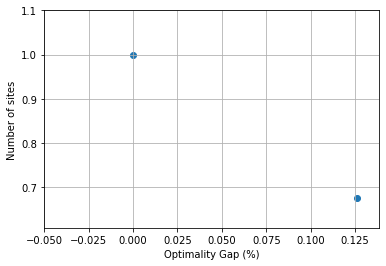

In [45]:
# Cost increase vs number of points
a = (costs_all.loc["Total"]/costs_all.loc["Total", cases_short[0]] - 1)*100
b = nbs_df.loc["RES"]/nbs_df.loc["RES", cases_short[0]]
print(pd.concat([a, b], axis=1).round(3))
plt.scatter(a, b)
plt.xlabel("Optimality Gap (%)")
plt.ylabel("Number of sites")
plt.xlim([-0.05, max(a)*1.1])
plt.ylim([min(b)*0.9, max(b)*1.1])
plt.grid()

In [58]:
# Comparing site in siting runs vs no siting, looking at the concepts of true positive etc
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1.1
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)
roc_table = pd.DataFrame(columns=cases_short[1:], index=["TP", "FP", "FN"])
for case in cases_short[1:]:
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))] # & (net.generators.p_nom_opt > min_cap)]
    # print(len(res_gens))
    siting_set = set(res_gens.index)
    # True positives are sites that were selected by the siting which were selected by the 1 stage
    common_set = nositing_set.intersection(siting_set)
    roc_table.loc["TP", case] = len(common_set)
    # False positives are sites that were selected by the siting but not by the 1 stage
    add_set = siting_set - nositing_set
    roc_table.loc["FP", case] = len(add_set)
    # False negatives are sites that were not selected by the siting and were selected by the 1 stage
    missing_set = nositing_set - siting_set
    roc_table.loc["FN", case] = len(missing_set)
print(roc_table)
prec_recall = pd.DataFrame(index=["Precision", "Recall"], columns=cases_short[1:], dtype=float)
# Percentage of locations in stage 1 that were selected (True Positive Rate)
prec_recall.loc["Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
# Percentage of selected location that were in stage 1 (1 - False Positive Rate)
prec_recall.loc["Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])
print((prec_recall*100).round(2))

# fpr = [0] + sorted(list(1-precision)) + [1]
# tpr = [0] + sorted(list(recall)) + [1]
#fpr = list(1-precision)
#tpr = list(recall)
#plt.plot(fpr, tpr)
#plt.scatter(fpr, tpr)
#plt.plot([0, 1], [0, 1])
#plt.xlim([0, 1])
#plt.ylim([0, 1])
#plt.xlabel("False Positive Rate")
#plt.ylabel("True Positive Rate")

   orangebars oneszeros
TP        166       145
FP       1098       525
FN          6        27
           orangebars  oneszeros
Precision       13.13      21.64
Recall          96.51      84.30


In [62]:
# Same per technology
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1e-3
for tech in techs:
    print(tech)
    nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
    nositing_set = set(nositing_res_gens.index)
    roc_table = pd.DataFrame(columns=cases_short[1:], index=["TP", "FP", "FN"])
    prec_recall = pd.DataFrame(columns=cases_short[1:], index=["Recall", "Precision"], dtype=float)
    for case in cases_short[1:]:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech)] # & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        # True positives are sites that were selected by the siting which were selected by the 1 stage
        common_set = nositing_set.intersection(siting_set)
        roc_table.loc["TP", case] = len(common_set)
        # False positives are sites that were selected by the siting but not by the 1 stage
        add_set = siting_set - nositing_set
        roc_table.loc["FP", case] = len(add_set)
        # False negatives are sites that were not selected by the siting and were selected by the 1 stage
        missing_set = nositing_set - siting_set
        roc_table.loc["FN", case] = len(missing_set)

    #print(roc_table)
    # Recall = Percentage of locations in stage 1 that were selected
    prec_recall.loc["Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
    # Precision = Percentage of selected location that were in stage 1
    prec_recall.loc["Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])
    print(f"\n{(prec_recall*100).round(2)}\n")

wind_onshore_national

           orangebars  oneszeros
Recall          96.17      90.24
Precision       62.44      70.77

wind_offshore_national

           orangebars  oneszeros
Recall          99.43      93.14
Precision       57.43      81.50

pv_utility_national

           orangebars  oneszeros
Recall          99.60      17.34
Precision       83.73      43.88

pv_residential_national

           orangebars  oneszeros
Recall          90.00        0.0
Precision        4.02        0.0



In [15]:
# Recall/precision per bus
techs = ["pv_utility_national", "pv_residential_national", "wind_onshore_national", "wind_offshore_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1e-3
prec_recall = pd.DataFrame(0., columns=["Precision", "Recall"], index=net.buses.index, dtype=float)
case = cases_short[2]
for bus in net.buses.index:
    # full lp
    nositing_res_gens = nositing_net.generators[(nositing_net.generators.bus == bus) 
                                                & (nositing_net.generators.type.isin(techs)) 
                                                & (nositing_net.generators.p_nom_opt > min_cap)]
    nositing_set = set(nositing_res_gens.index)
    # Reduced lp
    roc_table = pd.Series(0., index=["TP", "FP", "FN"])
    net = nets[case]
    res_gens = net.generators[(net.generators.bus == bus) & (net.generators.type.isin(techs))] # & (net.generators.p_nom_opt > min_cap)]
    # print(len(res_gens))
    siting_set = set(res_gens.index)
    # True positives are sites that were selected by the siting which were selected by the 1 stage
    common_set = nositing_set.intersection(siting_set)
    roc_table.loc["TP"] = len(common_set)
    # False positives are sites that were selected by the siting but not by the 1 stage
    add_set = siting_set - nositing_set
    roc_table.loc["FP"] = len(add_set)
    # False negatives are sites that were not selected by the siting and were selected by the 1 stage
    missing_set = nositing_set - siting_set
    roc_table.loc["FN"] = len(missing_set)
    # Percentage of locations in stage 1 that were selected (True Positive Rate)
    prec_recall.loc[bus, "Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
    # Percentage of selected location that were in stage 1 (1 - False Positive Rate)
    prec_recall.loc[bus, "Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])
print((prec_recall.sort_values(by="Precision")*100).round(2))

      Precision  Recall
name                   
BA        12.50  100.00
FI        18.03  100.00
EE        26.32  100.00
AL        33.33  100.00
ME        33.33  100.00
SK        33.33   50.00
NO        35.38  100.00
RS        42.86  100.00
RO        44.44   90.91
AT        46.15  100.00
HR        50.00   87.50
ES        51.39   86.05
SE        51.65  100.00
IE        55.26  100.00
GB        57.89  100.00
LV        58.33  100.00
DK        60.71  100.00
GR        61.76  100.00
CH        66.67  100.00
LU        66.67  100.00
NL        70.59  100.00
BG        73.68  100.00
CZ        75.00  100.00
PT        76.92  100.00
LT        76.92  100.00
BE        77.78  100.00
IT        78.57   97.06
HU        80.00   92.31
DE        81.61   91.03
FR        83.22   99.17
PL        92.00  100.00
MK          NaN     NaN
SI          NaN     NaN


<ipython-input-15-0462de770c14>:29: RuntimeWarning: invalid value encountered in double_scalars
  prec_recall.loc[bus, "Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
<ipython-input-15-0462de770c14>:31: RuntimeWarning: invalid value encountered in double_scalars
  prec_recall.loc[bus, "Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])
<ipython-input-15-0462de770c14>:29: RuntimeWarning: invalid value encountered in double_scalars
  prec_recall.loc[bus, "Recall"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FN'])
<ipython-input-15-0462de770c14>:31: RuntimeWarning: invalid value encountered in double_scalars
  prec_recall.loc[bus, "Precision"] = roc_table.loc['TP']/(roc_table.loc['TP']+roc_table.loc['FP'])


## Capacities

In [31]:
techs = ["ccgt", "pv_utility_national", "pv_residential_national",
         "wind_onshore_national", "wind_offshore_national",
         "AC", "DC", "Li-ion"]
capacities_df = pd.DataFrame(columns=cases_short, index=techs)
capacities_init_df = pd.DataFrame(columns=cases_short, index=techs)
for case in cases_short:
    net = nets[case]
    capacities = pd.concat([get_generators_capacity(net)["final"],
                            get_links_capacity(net)["new [TWkm]"] + get_links_capacity(net)["init [TWkm]"],
                            get_storage_energy_capacity(net)["new [GWh]"]])
    for tech in techs:
        capacities_df.loc[tech, case] = capacities[capacities.index.str.startswith(tech)].sum().round()
    # capacities_df[case] = capacities[techs].round().values
    capacities = pd.concat([get_generators_capacity(net)["init"],
                            get_links_capacity(net)["init [TWkm]"],
                            get_storage_power_capacity(net)["init [GW]"]])
    capacities_init_df[case] = capacities[techs].round().values
# capacities_df.round(3).to_csv("capacities.csv")
print(capacities_df)
#capacities_df.to_excel("capacities.xlsx")
#ax1 = capacities_df.plot(kind="bar")
#capacities_init_df.plot(ax=ax1, kind="bar", color='k', alpha=0.5)
#plt.xticks(rotation="45")
# plt.savefig(f"capacities_{year}.png", bbox_inches="tight")

                        full nopartition partitionglobal
ccgt                      88          82              88
pv_utility_national      321         304             329
pv_residential_national   75          51              84
wind_onshore_national    209         203             191
wind_offshore_national   473         483             478
AC                        85          93              84
DC                       169         182             173
Li-ion                    38          56              55


In [32]:
# Comparing site in siting runs vs no siting run -> how much capacity is not covered by siting
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)
total_cap = nositing_res_gens.p_nom_opt.sum()
total_gen = nositing_net.generators_t.p[nositing_res_gens.index].sum().sum()
print(f"Total cap: {total_cap:.3f} GW")
print(f"Total gen: {total_gen/1e3:.3f} TWh")

for case in cases_short[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
    print(f"Common sites cap: {common_sites_cap:.3f} ({common_sites_cap*100/total_cap:.2f}%)")
    # Generation
    common_sites_gen = nositing_net.generators_t.p[list(common_set)].sum().sum()
    print(f"Common sites gen: {common_sites_gen/1e3:.3f} ({common_sites_gen*100/total_gen:.2f}%)")

Total cap: 1077.977 GW
Total gen: 2767.386 TWh

nopartition
Common sites cap: 940.852 (87.28%)
Common sites gen: 2581.814 (93.29%)

partitionglobal
Common sites cap: 1018.430 (94.48%)
Common sites gen: 2655.972 (95.97%)


In [33]:
# Per tech
# Comparing site in siting runs vs no siting run -> how much capacity is not covered by siting
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1e-3

percentages_cap = pd.DataFrame(columns=cases_short[1:], index=techs, dtype=float)
percentages_gen = pd.DataFrame(columns=cases_short[1:], index=techs, dtype=float)
for tech in techs:
    nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech) 
                                                & (nositing_net.generators.p_nom_opt > min_cap)]
    nositing_set = set(nositing_res_gens.index)
    total_cap = nositing_res_gens.p_nom_opt.sum()
    total_gen = nositing_net.generators_t.p[nositing_res_gens.index].sum().sum()

    for case in cases_short[1:]:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech)]# & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        common_set = nositing_set.intersection(siting_set)
        # Capacity
        common_sites_cap = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
        percentages_cap.loc[tech, case] = common_sites_cap*100/total_cap
        # Generation
        common_sites_gen = (nositing_net.generators_t.p[list(common_set)]).sum().sum()
        percentages_gen.loc[tech, case] = common_sites_gen*100/total_gen

print("Capacity")
print(percentages_cap.round(2))
print("\nGeneration")
print(percentages_gen.round(2))

Capacity
                         nopartition  partitionglobal
wind_onshore_national          94.53            85.81
wind_offshore_national         99.05            98.67
pv_utility_national            78.38            92.64
pv_residential_national        30.84           100.00

Generation
                         nopartition  partitionglobal
wind_onshore_national          94.49            88.93
wind_offshore_national         99.39            98.77
pv_utility_national            81.04            92.08
pv_residential_national        33.52           100.00


In [35]:
# Per bus
techs = ["wind_onshore_national", "wind_offshore_national", "pv_residential_national", "pv_utility_national"]
nositing_net = nets[cases_short[0]]
min_cap = 1e-3
case = cases_short[1]
net = nets[case]
common_cap_gen = pd.DataFrame(index=net.buses.index, columns=["Capacity", "Generation"])
for bus in net.buses.index:
    # full lp
    nositing_res_gens = nositing_net.generators[(nositing_net.generators.bus == bus) 
                                                & (nositing_net.generators.type.isin(techs)) 
                                                & (nositing_net.generators.p_nom_opt > min_cap)]
    nositing_set = set(nositing_res_gens.index)
    total_cap = nositing_res_gens.p_nom_opt.sum()
    total_gen = nositing_net.generators_t.p[nositing_res_gens.index].sum().sum()
    # reduced lp
    res_gens = net.generators[(net.generators.bus == bus) & (net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
    #common_sites_cap = res_gens.loc[list(siting_set)].p_nom_opt.sum()
    common_cap_gen.loc[bus, "Capacity"] =  common_sites_cap*100/total_cap
    # Generation
    common_sites_gen = nositing_net.generators_t.p[list(common_set)].sum().sum()
    #common_sites_gen = net.generators_t.p[list(siting_set)].sum().sum()
    common_cap_gen.loc[bus, "Generation"] = common_sites_gen*100/total_gen
print(common_cap_gen.loc[["RO", "GB", "IE"]].sort_values(by="Capacity"))

     Capacity Generation
name                    
GB    94.2265    97.2238
RO    98.8103    99.5615
IE    99.8037    99.9532


<ipython-input-35-515ffbd6ceca>:23: RuntimeWarning: invalid value encountered in double_scalars
  common_cap_gen.loc[bus, "Capacity"] =  common_sites_cap*100/total_cap
<ipython-input-35-515ffbd6ceca>:27: RuntimeWarning: invalid value encountered in double_scalars
  common_cap_gen.loc[bus, "Generation"] = common_sites_gen*100/total_gen
<ipython-input-35-515ffbd6ceca>:23: RuntimeWarning: invalid value encountered in double_scalars
  common_cap_gen.loc[bus, "Capacity"] =  common_sites_cap*100/total_cap
<ipython-input-35-515ffbd6ceca>:27: RuntimeWarning: invalid value encountered in double_scalars
  common_cap_gen.loc[bus, "Generation"] = common_sites_gen*100/total_gen


### Load

In [36]:
print(f"Total load: {net.loads_t.p.sum().sum()/1e3}")
for case in cases_short:
    net = nets[case]
    load_shed = net.generators[net.generators.type == "load"]
    print(net.generators_t.p[load_shed.index].sum().sum()/1e3)

Total load: 3227.5096914999963
0.23535756752350273
0.2569184068124426
0.30935777920304536


### Generation

In [54]:
techs = ['wind_onshore_national', 'wind_offshore_national', 'pv_residential_national', 'pv_utility_national']

generation_df = pd.DataFrame(columns=cases_short, index=techs_generic)
ccgt_generation_df = pd.DataFrame(columns=cases_short, index=["Capacity (GW)", "Generation (TWh)"], dtype=float)
for case in cases_short:
    print(case)
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    total_cap = res_gens.p_nom_opt.sum()
    total_gen = (net.generators_t.p[res_gens.index]).sum().sum()
    print(f"Total capacity: {total_cap:.2f}")
    print(f"Total generation: {total_gen/1e3:.2f}")
    ccgt_gens = net.generators[net.generators.type == 'ccgt']
    ccgt_generation_df.loc["Capacity (GW)", case] = ccgt_gens.p_nom_opt.sum()
    ccgt_generation_df.loc["Generation (TWh)", case] = net.generators_t.p[ccgt_gens.index].sum().sum()/1e3
    print()
print(ccgt_generation_df.round(2))

2016
Total capacity: 1036.28
Total generation: 2705.00

2017
Total capacity: 969.37
Total generation: 2785.67

2018
Total capacity: 1077.99
Total generation: 2767.40

                    2016   2017   2018
Capacity (GW)     115.11  72.46  87.51
Generation (TWh)   43.39  38.84  36.77


### Potential

### Transmission

In [ ]:
# Capacity overall
capacities_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net)
    capacities_df["init"] = capacities["init [TWkm]"]
    capacities_df[case] = capacities["new [TWkm]"]
capacities_df.loc["Total"] = capacities_df.loc["AC"] + capacities_df.loc["DC"]
print(f"Added capacity:\n {capacities_df}")

# In Europe
"""
capacities_eu_df = pd.DataFrame(index=["AC", "DC"], columns=["init"] + cases)
outside_nodes = regions_dict["GLIS"] + regions_dict["NA"]
print(outside_nodes)
for case in cases:
    net = nets[case]
    capacities = get_links_capacity(net, outside_nodes)
    capacities_eu_df["init"] = capacities["init [TWkm]"]
    capacities_eu_df[case] = capacities["new [TWkm]"]
print(f"Added capacity:\n {capacities_eu_df}")
"""
0

In [ ]:
# Maps of flows
from postprocessing.plotly import SizingPlotly

for case in cases:
    net = nets[case]
    sp = SizingPlotly(net)
    #fig = sp.plot_topology()
    #fig = sp.plot_capacity("init")
    #fig.show()
    fig = sp.plot_capacity("final")
    fig.show()
    #fig.write_image(f"transmission_capacity_{case}.png", dpi=300)
    # fig.write_html(f"{case}_topology_heatmap.html", auto_open=True)

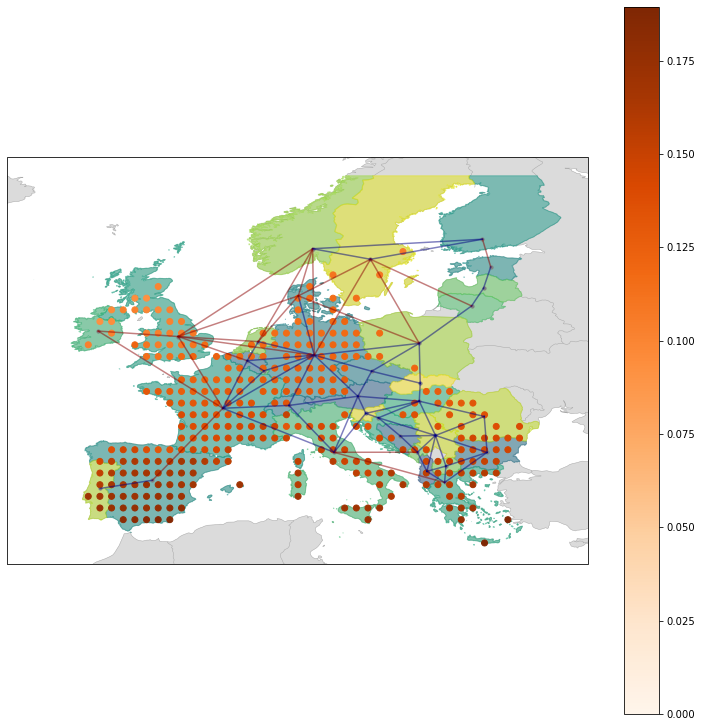

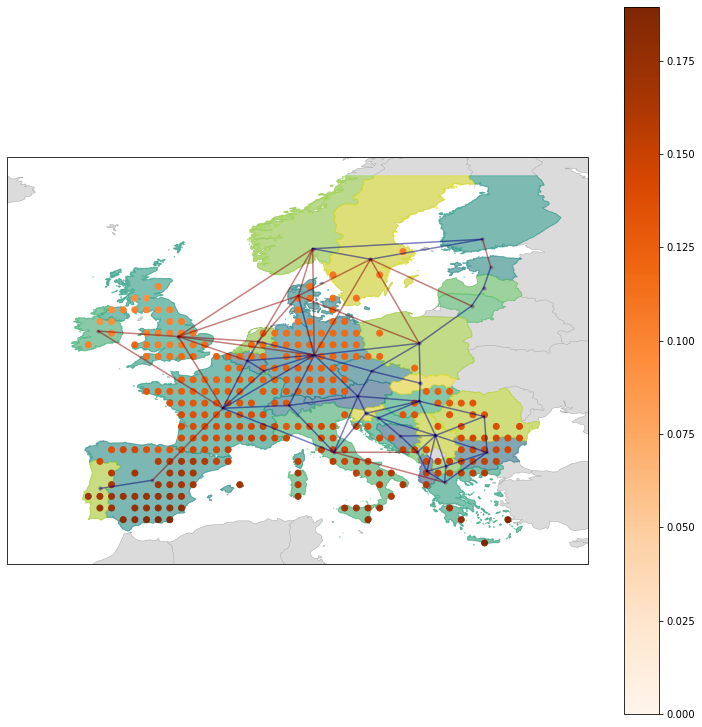

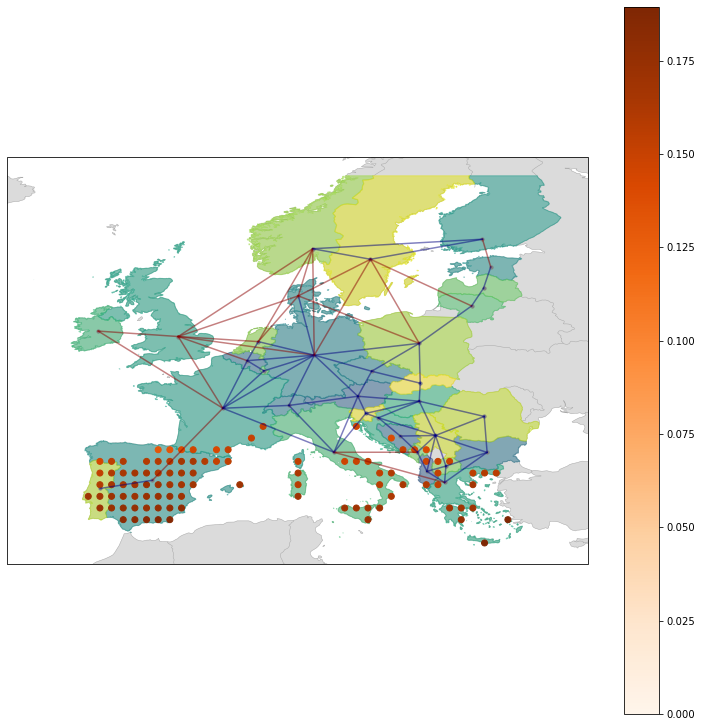

In [60]:
from iepy.topologies.core.plot import plot_topology
import shapely.wkt

# !!! Why are sites exploited at the maximum of their potential????

min_cap = 0
for case in cases_short:
    net = nets[case]
    net.buses["onshore_region"] = net.buses.region.apply(lambda x: shapely.wkt.loads(x))
    net.buses["offshore_region"] = None
    ax = plot_topology(net.buses, net.links)
    techs = ["pv_utility_national"]
    res_generators = net.generators[(net.generators.type.isin(techs)) & (net.generators.p_nom_opt >= min_cap)]
    x = res_generators.loc[res_generators.index, "x"].values
    y = res_generators.loc[res_generators.index, "y"].values
    #values = res_generators.p_nom_opt.values
    #values = (res_generators.p_nom_opt/res_generators.p_nom_max).values
    values = net.generators_t.p_max_pu[res_generators.index].mean()
    map1 = ax.scatter(x, y, c=values, cmap='Oranges', vmin=0)
    plt.colorbar(map1, ax=ax)

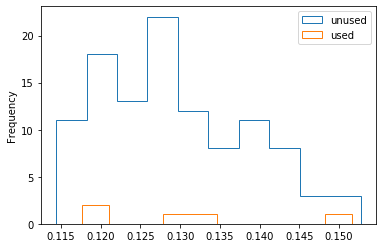

<Figure size 432x288 with 0 Axes>

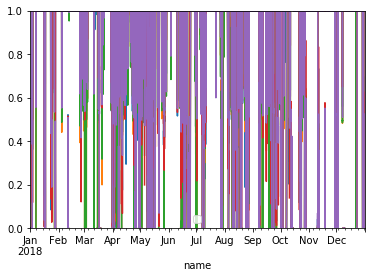

In [242]:
# Percentage of sites with max capacity
min_cap = 0
for case in cases_short[1:]:
    net = nets[case]
    techs = ["pv_utility_national"]
    res_generators = net.generators[(net.generators.type.isin(techs)) & (net.generators.p_nom_opt >= min_cap)]
    values = res_generators.p_nom_opt.round(2)
    #values = (res_generators.p_nom_opt/res_generators.p_nom_max).round(2)
    not_full_potential = values[values < 1]
    full_potential = values[values >= 1]
    plt.figure()
    net.generators_t.p_max_pu[not_full_potential.index].mean().plot(kind="hist", histtype="step")
    net.generators_t.p_max_pu[full_potential.index].mean().plot(kind="hist", histtype="step")
    plt.legend(["unused", "used"])
    # Percentage of capacity factor used
    max_generation = net.generators_t.p_max_pu[full_potential.index]*net.generators.loc[full_potential.index].p_nom_opt
    generation = net.generators_t.p[full_potential.index]
    plt.figure()
    (generation/max_generation).plot()
    plt.ylim([0, 1])
    plt.legend("")
    #values = net.generators_t.p_max_pu[res_generators.index].mean()
    #values.plot(kind="hist", cumulative=True, histtype="step", density=True)
    #plt.xlim([0, 1])

In [142]:
# Res aggregated signal
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national"]
min_cap = 0
cases_tested = cases_short[:1]
for tech in techs:
    plt.figure()
    for case in cases_tested:
        net = nets[case]
        res_gens = net.generators[(net.generators.type == tech) & (net.generators.p_nom_opt >= min_cap)]
        # Capacity factor average per site
        res_gens_p_max_pu = net.generators_t.p_max_pu[res_gens.index]
        res_gens_p_max_pu_agg = res_gens_p_max_pu.mean(axis=0)
        # Total generation potential (over the time period considered) per site
        #res_gens_p_max_pu = net.generators_t.p_max_pu[res_gens.index]*res_gens.p_nom_max
        #res_gens_p_max_pu_agg = res_gens_p_max_pu.sum(axis=0)
        #res_gens_p_max_pu_agg.plot(kind="hist", bins=50, histtype="step")
        res_gens_p_max_pu_agg.plot(kind="kde")

    plt.legend(cases_tested, loc="upper left")
    plt.xlim([0, 0.6])
    plt.title(tech)

AttributeError: 'DataFrame' object has no attribute 'arg_max'

<Figure size 432x288 with 0 Axes>

Yearly RES penetration
82.74
0.8299900962329088
83.37
0.8361331331937654
82.37
0.8264169387471961


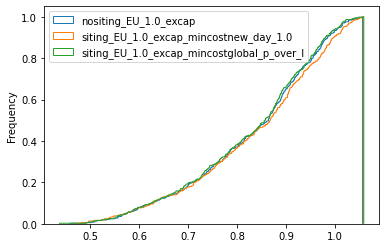

In [38]:
# Res penetration
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national"]
time_agg = net.loads_t.p.index.date
load_grouped = net.loads_t.p.groupby(time_agg).sum().sum(axis=1)
load = net.loads_t.p.sum().sum()
# print(load)
print("Yearly RES penetration")
for case in cases_short:
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    res_gens_p = net.generators_t.p[res_gens.index]
    print(f"{res_gens_p.sum().sum()*100/load:.2f}")
    res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
    print((res_prod_grouped/load_grouped).mean())
    if 0:
        peak_t = load_grouped.idxmax()
        res_gens_p = net.generators_t.p_max_pu[res_gens.index] * res_gens.p_nom_max
        res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
        print(res_prod_grouped.loc[peak_t]/load_grouped.loc[peak_t])
    #(res_prod_grouped/load_grouped).plot(kind="kde")
    (res_prod_grouped/load_grouped).plot(kind="hist", density="True", cumulative="True", histtype='step', bins=1000)
plt.legend(cases, loc="upper left")

name
AL    18
AT     9
BA    18
BE     9
BG    17
CH    10
CZ     9
DE    10
DK    16
EE     8
ES    11
FI    17
FR    10
GB    17
GR    17
HR    18
HU    17
IE    17
IT    17
LT     8
LU    11
LV     8
ME    18
MK    18
NL    16
NO     8
PL    10
PT    19
RO    17
RS    18
SE     9
SI    17
SK    10
dtype: object
[1.2659, 0.0731, 1.0846, 0.0587, 0.5765, 0.0023, 0.0221, 0.2957, 3.1307, 8.8858, 9.717, 1.9653, 0.7052, 3.4065, 1.5496, 1.3877, 0.135, 12.865, 0.5893, 0.7468, 0.4985, 5.2361, 1.5028, 0.3946, 1.2324, 1.1226, 0.3744, 2.074, 1.9757, 0.1195, 2.3783, 0.0013, 0.014]


<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

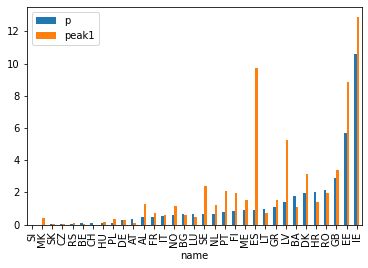

<Figure size 432x288 with 0 Axes>

In [17]:
# Res penetration per bus
techs_wind = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national"]
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
time_agg = net.loads_t.p.index.hour
case = cases_short[0]
measures = ["p", "peak1"]
penetration = pd.DataFrame(columns=measures, index=net.buses.index, dtype=float)
peak_days = pd.Series(index=net.buses.index, dtype=str)
net = nets[case]
for measure in measures:
    for bus in net.buses.index:
        load_at_bus = net.loads[net.loads.bus == bus]
        load_grouped = net.loads_t.p[load_at_bus.index].groupby(time_agg).sum().squeeze()
        if measure == "p":
            res_gens = net.generators[(net.generators.type.isin(techs)) & (net.generators.bus == bus)]
            res_gens_p = net.generators_t.p[res_gens.index]
            res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
            penetration.loc[bus, measure] = (res_prod_grouped/load_grouped).mean()
        elif measure == "potential":
            res_gens = net.generators[(net.generators.type.isin(techs_wind)) & (net.generators.bus == bus)]
            res_gens_p = net.generators_t.p_max_pu[res_gens.index] * res_gens.p_nom_max
            res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
            penetration.loc[bus, measure] = (res_prod_grouped/load_grouped).mean()
        elif measure == "peak1":
            peak_t = load_grouped.idxmax()
            peak_days[bus] = peak_t
            res_gens = net.generators[(net.generators.type.isin(techs_wind)) & (net.generators.bus == bus)]
            res_gens_p = net.generators_t.p_max_pu[res_gens.index] * res_gens.p_nom_max
            res_prod_grouped = res_gens_p.groupby(time_agg).sum().sum(axis=1)
            penetration.loc[bus, measure] = res_prod_grouped.loc[peak_t]/load_grouped.loc[peak_t]
        else:
            peak_t = load_grouped.idxmax()
            res_gens = net.generators[(net.generators.type.isin(techs)) & (net.generators.bus == bus)]
            penetration.loc[bus, measure] = res_gens.p_nom_max.sum()/load_grouped.loc[peak_t]
plt.figure()
print(peak_days)
print(penetration["peak1"].round(4).to_list())
sorted_penetration = penetration.sort_values(by=["p"])
#ax = pd.Series(0., index=sorted_penetration.index).plot(color='k')
sorted_penetration.plot(kind="bar")
#plt.ylim([0, 1])

In [148]:
# Comparing site in siting runs vs no siting run
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases_short[0]]
nositing_res_gens = nositing_net.generators[nositing_net.generators.type.isin(techs)]
for case in cases_short[1:]:
    net = nets[case]
    res_gens = net.generators[net.generators.type.isin(techs)]
    # Compare p_nom_max
    p_nom_max_diff = nositing_res_gens.loc[res_gens.index, "p_nom_max"] - res_gens["p_nom_max"]
    print("Sites with different p_nom_max: ", p_nom_max_diff[p_nom_max_diff != 0])
    # Compare p_nom_min
    p_nom_min_diff = nositing_res_gens.loc[res_gens.index, "p_nom_min"] - res_gens["p_nom_min"]
    print("Sites with different p_nom_min: ", p_nom_min_diff[p_nom_min_diff != 0])
    p_diff = nositing_net.generators_t.p_max_pu[res_gens.index] - net.generators_t.p_max_pu[res_gens.index]
    locs_with_diff = res_gens.index[(p_diff != 0).sum() != 0]
    print(locs_with_diff)

Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')
Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')
Sites with different p_nom_max:  Series([], Name: p_nom_max, dtype: float64)
Sites with different p_nom_min:  Series([], Name: p_nom_min, dtype: float64)
Index([], dtype='object', name='name')


In [78]:
# Are common sites used similarly?
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)

for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap_1_stage = nositing_res_gens.loc[list(common_set)].p_nom_opt.sum()
    common_sites_cap_2_stage = res_gens.loc[list(common_set)].p_nom_opt.sum()
    print(f"Capacity in common sites (1 vs 2): {common_sites_cap_1_stage:.3f} - {common_sites_cap_2_stage:.3f}")
    # Generation
    common_sites_gen_1_stage = nositing_net.generators_t.p[list(common_set)].sum().sum()
    common_sites_gen_2_stage = net.generators_t.p[list(common_set)].sum().sum()
    print(f"Gen from common sites (1 vs 2): {common_sites_gen_1_stage/1e3:.3f} - {common_sites_gen_2_stage/1e3:.3f}")
    


siting_day_0.9
Capacity in common sites (1 vs 2): 993.778 - 1044.643
Gen from common sites (1 vs 2): 28627.542 - 30874.971

siting_day_0.8
Capacity in common sites (1 vs 2): 926.939 - 977.175
Gen from common sites (1 vs 2): 27482.913 - 29242.074

siting_week_0.8
Capacity in common sites (1 vs 2): 782.845 - 789.588
Gen from common sites (1 vs 2): 24954.540 - 25680.253


In [104]:
# Comparing site per site?
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3
nositing_res_gens = nositing_net.generators[(nositing_net.generators.type.isin(techs)) 
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
nositing_set = set(nositing_res_gens.index)

percentage_diff = pd.DataFrame(columns=cases[1:], index=["1GW", "1MW", "1kW", "1W"], dtype=float)
for case in cases[1:]:
    print()
    print(case)
    net = nets[case]
    res_gens = net.generators[(net.generators.type.isin(techs))]# & (net.generators.p_nom_opt > min_cap)]
    siting_set = set(res_gens.index)
    common_set = nositing_set.intersection(siting_set)
    # Capacity
    common_sites_cap_1_stage = nositing_res_gens.loc[list(common_set)].p_nom_opt
    common_sites_cap_2_stage = res_gens.loc[list(common_set)].p_nom_opt
    cap_diff = (common_sites_cap_1_stage - common_sites_cap_2_stage) #.abs()
    for v, s in [(1, "1GW"), (1e-3, "1MW"), (1e-6, "1kW"), (1e-9, "1W")]:
        cap_diff_ = cap_diff[cap_diff.abs() > v]
        percentage_diff.loc[s, case] = (1-len(cap_diff_)/len(common_set))*100
        
        #print(f"Diff of capacity: {cap_diff.abs().sum():.3f} out of ({common_sites_cap_1_stage.sum():.3f})")
        #print(f"Number of sites with diff capacity: {len(cap_diff_)} (out of {len(common_set)} common sites)")
        """
        plt.figure()
        cap_diff.plot(kind="hist", histtype="step", cumulative=True, bins=len(cap_diff), density=True)
        plt.xlabel("Capacity difference (1 stage - 2 stage) (GW)")
        plt.title(case)
        """
        # Generation
        #common_sites_gen_1_stage = (nositing_net.generators_t.p[list(common_set)]*nositing_res_gens.loc[list(common_set)].p_nom_opt)
        #common_sites_gen_2_stage = (net.generators_t.p[list(common_set)]*res_gens.loc[list(common_set)].p_nom_opt)
        #gen_diff = (common_sites_gen_1_stage - common_sites_gen_2_stage).abs().sum()
        #print(f"Diff of generation: {gen_diff.sum()/1e3:.3f} (out of {common_sites_gen_1_stage.sum().sum()/1e3:.3f})")
        # print(f"Number of sites with diff generation: {(gen_diff > 1).sum()}")    
        
print(f"Percentage of points with capacity difference below:\n{percentage_diff.round(2)}")


siting_1.0_day_0.9

siting_1.0_week_0.9
Percentage of points with capacity difference below:
     siting_1.0_day_0.9  siting_1.0_week_0.9
1GW               97.71                99.49
1MW               97.18                99.49
1kW               97.00                99.32
1W                96.83                99.15


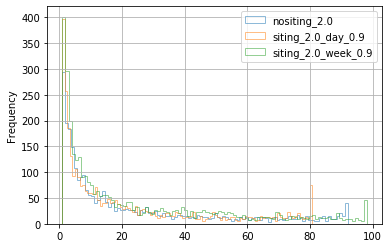

In [44]:
# CCGT usage
for case in cases:
    net = nets[case]
    ccgt_gens = net.generators[net.generators.type == "ccgt"]
    ccgt_p = net.generators_t.p[ccgt_gens.index]
    ccgt_p_sum = ccgt_p.sum(axis=1)
    ccgt_p_sum_pos = ccgt_p_sum[ccgt_p_sum >= 1]
    ccgt_p_sum_pos.plot(kind="hist", bins=100, alpha=0.5, histtype="step")
    # ccgt_p_sum_pos.plot(kind="kde", alpha=0.8)
plt.legend(cases)
plt.grid()

In [43]:
# Storage
techs = ["Li-ion", "phs"]
cycles = pd.DataFrame(columns=cases, index=techs)
for case in cases:
    net = nets[case]
    for tech in techs:
        sus = net.storage_units[net.storage_units.type == tech]
        capacity = (sus.p_nom_opt * sus.max_hours).sum()
        su_ps = net.storage_units_t.p[sus.index]
        intake = -su_ps.where(su_ps < 0, 0).sum().sum()
        cycles.loc[tech, case] = intake/capacity
print(cycles)

       nositing_2.0 siting_2.0_day_0.9 siting_2.0_week_0.9
Li-ion       475.46            371.934             390.362
phs         55.8522            52.6221             49.7098


In [58]:
# Hydro production
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national"]
time_agg = net.loads_t.p.index.date
load_grouped = net.loads_t.p.groupby(time_agg).sum().sum(axis=1)
load = net.loads_t.p.sum().sum()
# print(load)
print("Yearly RES penetration")
for case in cases_short:
    net = nets[case]
    # Ror
    rors = net.generators[net.generators.type == "ror"]
    rors_p = net.generators_t.p_max_pu[rors.index] * rors.p_nom_opt
    rors_p_grouped = rors_p.groupby(time_agg).sum().sum(axis=1)
    print(round((rors_p_grouped/load_grouped).mean(), 3))
    # Sto
    stos = net.storage_units[net.storage_units.type == "sto"]
    stos_p = net.storage_units_t.inflow[stos.index]
    stos_p_grouped = stos_p.groupby(time_agg).sum().sum(axis=1)
    print(round((stos_p_grouped/load_grouped).mean(), 3))
    #(res_prod_grouped/load_grouped).plot(kind="kde")


Yearly RES penetration
0.044
0.132
0.044
0.132
0.044
0.132


In [95]:
import itertools
from geopy import distance
techs = ["wind_onshore_national", "wind_offshore_national", "pv_utility_national", "pv_residential_national"]
nositing_net = nets[cases[0]]
min_cap = 1e-3

for case in cases_short[1:]:
    print('----------------')    
    print(f'Run {case}')
    net = nets[case]
    min_distances = {k: [] for k in techs}
    for tech in techs:
        
        nositing_res_gens = nositing_net.generators[(nositing_net.generators.type == tech)
                                            & (nositing_net.generators.p_nom_opt > min_cap)]
        nositing_set = set(nositing_res_gens.index)
    
        res_gens = net.generators[net.generators.type == tech]# & (net.generators.p_nom_opt > min_cap)]
        siting_set = set(res_gens.index)
        intersection = nositing_set.intersection(siting_set)
        min_distances[tech].extend(list(itertools.repeat(0, len(intersection))))
        sites_excl_one = nositing_set.difference(siting_set)
        sites_excl_two = siting_set.difference(nositing_set)
        all_pairs = list(itertools.product(sites_excl_one, sites_excl_two))
        if not len(all_pairs) and len(sites_excl_one):
            print(f'All {tech} sites picked in siting stage are also in the one-stage set. {len(sites_excl_one)} sites less in the siting stage.')
        elif not len(all_pairs) and len(sites_excl_two):
            print(f'All {tech} sites picked in one stage were picked in the siting stage. {len(sites_excl_two)} sites less in the one-stage.')
        elif len(all_pairs):
            df_pairs = pd.DataFrame(columns=['site1', 'site2', 'dist'], index=np.arange(len(all_pairs)))
            for i, t in enumerate(all_pairs):
                df_pairs.loc[i, 'site1'] = tuple(nositing_res_gens.loc[t[0], ["x", "y"]])
                df_pairs.loc[i, 'site2'] = tuple(res_gens.loc[t[1], ["x", "y"]])
                df_pairs.loc[i, 'dist'] = distance.distance(df_pairs.loc[i, 'site1'], df_pairs.loc[i, 'site2']).km
            while df_pairs.shape[0] > 0:
                df_mindist = df_pairs[df_pairs.dist == df_pairs.dist.min()].iloc[0]
                min_distances[tech].append(df_mindist.dist)
                site1_out = df_mindist['site1']
                site2_out = df_mindist['site2']
                df_pairs = df_pairs[(df_pairs.site1 != site1_out) & (df_pairs.site2 != site2_out)]
            if len(sites_excl_one) > len(sites_excl_two):
                print(f'{len(sites_excl_one)-len(sites_excl_two)} one-stage {tech} sites with no match in siting')
            else:
                print(f'{len(sites_excl_two)-len(sites_excl_one)} siting {tech} sites with no match in one-stage')
        hist, bins, _ = plt.hist(min_distances[tech], bins=100, density=True, cumulative=True, histtype='step', label=tech)
    #plt.title(str(time.split('_')[-1]))
    plt.legend(ncol=2, loc='lower right')
    plt.xlabel('Distance [km]')
    plt.ylabel('Probability [-]')
    plt.show()

KeyError: 'nositing_CWE_0.5_excap'

## David's code

In [ ]:
import pandas as pd
import pickle
from os.path import join
import sys
from geopy import distance
import matplotlib.pyplot as plt
import numpy as np
import itertools

path_to_folder = '../../../git_github/replan/output/sizing/tyndp2018/'
techs = ['wind_onshore_national', 'wind_offshore_national', 'pv_residential_national', 'pv_utility_national']
# techs_final = ['w_on', 'w_off', 'pv_res', 'pv_util']
runs = []
reference_run = join(path_to_folder, 'CWE_siting_no_1deg_2018_Gurobi')
runs.append(reference_run)
comparison_run = join(path_to_folder, 'CWE_siting_yes_1deg_1.0_hour_2018_Gurobi')
runs.append(comparison_run)
# Site selection & recall and precision computation.
mindex = pd.MultiIndex.from_product([techs, ['r', 'p']], names=['tech', 'metric'])
df = pd.DataFrame(columns=techs, index=[r.split('/')[-1] for r in runs])
df_recall = pd.DataFrame(columns=mindex, index=[r.split('/')[-1] for r in runs[1:]])
for r in runs:
    try:
        with open(join(r, 'resite/resite_instance.p'), 'rb') as f:
            instance = pickle.load(f)
        sel_sites_dict = instance.sel_tech_points_dict
        all_points_dict = instance.tech_points_dict
    except FileNotFoundError:
        flp_generators_data = pd.read_csv(join(r, 'generators.csv'), index_col=0)
        sel_sites_dict = {tech: None for tech in techs}
        all_points_dict = {tech: None for tech in techs}
        for tech in techs:
            sites_tech_all = flp_generators_data[flp_generators_data.type == tech]
            all_points_dict[tech] = list(zip(sites_tech_all.x, sites_tech_all.y))
            sites_tech = sites_tech_all[sites_tech_all.p_nom_opt >= 1e-3]
            sites_tech = list(zip(sites_tech.x, sites_tech.y))
            sel_sites_dict[tech] = set(sites_tech)
        ref_sites = sel_sites_dict
    common_set_total = 0.
    fullLP_only_set_total = 0.
    reducedLP_only_set_total = 0.
    for tech in techs:
        try:
            sel_sites = set(sel_sites_dict[tech])
            sel_sites_out_of_total = str(len(sel_sites_dict[tech])) + '/' + str(len(all_points_dict[tech]))
        except KeyError:
            sel_sites = set([])
            sel_sites_out_of_total = str(0) + '/' + str(len(all_points_dict[tech]))
        df.loc[r.split('/')[-1], tech] = sel_sites_out_of_total
        common_set = set(ref_sites[tech]).intersection(sel_sites)
        common_set_total += len(common_set)
        fullLP_only_set = set(ref_sites[tech]).difference(sel_sites)
        fullLP_only_set_total += len(fullLP_only_set)
        fullLP_only_set_total += len(common_set)
        reducedLP_only_set = sel_sites.difference(set(ref_sites[tech]))
        reducedLP_only_set_total += len(reducedLP_only_set)
        reducedLP_only_set_total += len(common_set)
        try:
            recall = len(common_set) / (len(common_set) + len(fullLP_only_set))
            prec = len(common_set) / (len(common_set) + len(reducedLP_only_set))
        except ZeroDivisionError:
            recall = 0
            prec = 0
        if r == runs[1]:
            df_recall.loc[r.split('/')[-1], (tech, 'r')] = round(recall, 2)
            df_recall.loc[r.split('/')[-1], (tech, 'p')] = round(prec, 2)
    recall_overall = common_set_total / fullLP_only_set_total
    precision_overall = common_set_total / reducedLP_only_set_total
    df_recall.loc[r.split('/')[-1], ('overall', 'r')] = round(recall_overall, 3)
    df_recall.loc[r.split('/')[-1], ('overall', 'p')] = round(precision_overall, 3)
# df.columns = techs_final
print(df.to_string())
# df_recall.columns.set_levels(techs_final, level=0, inplace=True)
print(df_recall.to_string())
#  Plotting cdf of site matching (prob vs dist)
for r in runs[1:]:
    try:
        with open(join(r, 'resite/resite_instance.p'), 'rb') as f:
            instance = pickle.load(f)
        sel_sites_dict = instance.sel_tech_points_dict
        all_points_dict = instance.tech_points_dict
        min_distances = {k: [] for k in techs}
        intersection_dict = {k: [] for k in techs}
        for tech in techs:
            try:
                intersection = set(ref_sites[tech]).intersection(set(sel_sites_dict[tech]))
                min_distances[tech].extend(list(itertools.repeat(0, len(intersection))))
                sites_excl_one = set(ref_sites[tech]).difference(set(sel_sites_dict[tech]))
                sites_excl_two = set(sel_sites_dict[tech]).difference(set(ref_sites[tech]))
                all_pairs = list(itertools.product(sites_excl_one, sites_excl_two))
                intersection_dict[tech] = intersection
            except KeyError:
                print(f'{tech} had an empty set.')
                continue
            if not all_pairs:
                print(f'{tech} fully matched. {len(sites_excl_two)-len(sites_excl_one)} extra sites for siting.')
            if len(all_pairs):
                df_pairs = pd.DataFrame(columns=['site1', 'site2', 'dist'], index=np.arange(len(all_pairs)))
                for i, t in enumerate(all_pairs):
                    df_pairs.loc[i, 'site1'] = t[0]
                    df_pairs.loc[i, 'site2'] = t[1]
                    df_pairs.loc[i, 'dist'] = distance.distance(t[0], t[1]).km
                while df_pairs.shape[0] > 0:
                    df_mindist = df_pairs[df_pairs.dist == df_pairs.dist.min()].iloc[0]
                    min_distances[tech].append(df_mindist.dist)
                    site1_out = df_mindist['site1']
                    site2_out = df_mindist['site2']
                    df_pairs = df_pairs[(df_pairs.site1 != site1_out) & (df_pairs.site2 != site2_out)]
                if len(sites_excl_one) > len(sites_excl_two):
                    print(f'{len(sites_excl_one)-len(sites_excl_two)} one-stage {tech} sites with no match in siting.')
                elif len(sites_excl_one) < len(sites_excl_two):
                    print(f'{len(sites_excl_two)-len(sites_excl_one)} siting {tech} sites with no match in one-stage.')
            hist, bins, _ = plt.hist(min_distances[tech], bins=100, density=True, cumulative=True, histtype='step', label=tech)
        plt.title(r.split('/')[-1])
        plt.legend(ncol=2, loc='lower right')
        plt.xlabel('Distance [km]')
        plt.ylabel('Probability [-]')
        plt.show()
    except FileNotFoundError:
        continue
# Overall capacity matching.
print('---------------------')
flp_generators_data = pd.read_csv(join(reference_run, 'generators.csv'), index_col=0)
flp_per_tech = {tech: None for tech in techs}
for tech in techs:
    sites_tech_all = flp_generators_data[flp_generators_data.type == tech]
    sites_tech = sites_tech_all[sites_tech_all.p_nom_opt >= 1e-3]
    flp_per_tech[tech] = sites_tech.p_nom_opt.sum()
df_cap = pd.Series(index=techs)
rlp_generators_data = pd.read_csv(join(comparison_run, 'generators.csv'), index_col=0)
for tech in techs:
    sites_tech_all = rlp_generators_data[rlp_generators_data.type == tech].copy()
    sites_tech_all['location'] = list(zip(sites_tech_all.x, sites_tech_all.y))
    sites_keep = sites_tech_all[sites_tech_all['location'].isin(intersection_dict[tech])]
    share = sites_keep.p_nom_opt.sum()/flp_per_tech[tech]
    df_cap.loc[tech] = str(round(share*100, 0)) + '%/' + str(round(flp_per_tech[tech], 2)) + 'GW'
# df_cap.index = techs_final
print(df_cap.to_string())
print('---------------------')
# Plotting cdf of site-by-site capacity matching (prob vs capacity)
for tech in techs:
    flp_sites_tech_all = flp_generators_data[flp_generators_data.type == tech]
    flp_sites_tech_all = flp_sites_tech_all[flp_sites_tech_all.p_nom_opt >= 1e-3].copy()
    flp_sites_tech_all['location'] = list(zip(flp_sites_tech_all.x, flp_sites_tech_all.y))
    flp_sites_keep = flp_sites_tech_all[flp_sites_tech_all['location'].isin(intersection_dict[tech])]
    rlp_sites_tech_all = rlp_generators_data[rlp_generators_data.type == tech].copy()
    rlp_sites_tech_all['location'] = list(zip(rlp_sites_tech_all.x, rlp_sites_tech_all.y))
    rlp_sites_keep = rlp_sites_tech_all[rlp_sites_tech_all['location'].isin(intersection_dict[tech])]
    delta_cap_dict = {k: None for k in intersection_dict[tech]}
    list_vals = []
    for k in delta_cap_dict:
        diff = flp_sites_keep[flp_sites_keep['location'] == k]['p_nom_opt'] - \
                            rlp_sites_keep[rlp_sites_keep['location'] == k]['p_nom_opt']
        delta_cap_dict[k] = round(float(diff), 3)
        list_vals.append(round(float(diff), 3))
    hist, bins, _ = plt.hist(list_vals, bins=100,
                             density=True, cumulative=True, histtype='step', label=tech)
plt.title(r.split('/')[-1])
plt.legend(ncol=2, loc='upper left')
plt.xlabel('Capacity difference [GW]')
plt.ylabel('Probability [-]')
plt.show()
print('---------------------')
# Capacity and electricity generation break-down per region/country.
# regions = {'BritishIsles': ['IE', 'GB'],
#            'CWE': ['FR', 'DE', 'LU', 'NL', 'BE'],
#            'Scandinavia': ['FI', 'DK', 'SE', 'NO'],
#            'Iberia': ['ES', 'PT'],
#            'CentralSouth': ['IT', 'CH', 'AT', 'SI'],
#            'Balkans': ['RO', 'BG', 'GR', 'MK', 'ME', 'AL', 'BA', 'RS'],
#            'CentralEast': ['EE', 'LT', 'LV', 'PL', 'SK', 'CZ', 'HU']}
regions = {'FR': ['FR'],
           'DE': ['DE'],
           'LU': ['LU'],
           'NL': ['NL'],
           'BE': ['BE']}
mindex_cols = pd.MultiIndex.from_product([techs, ['cap', 'gen']], names=['tech', 'metric'])
mindex_index = pd.MultiIndex.from_product([[r for r in regions], [run.split('/')[-1] for run in runs]],
                                          names=['run', 'region'])
df_regions = pd.DataFrame(columns=mindex_cols, index=mindex_index)
for r in runs:
    cap_data = pd.read_csv(join(r, 'generators.csv'), index_col=0)
    gen_data = pd.read_csv(join(r, 'generators-p.csv'), index_col=0)
    for tech in techs:
        cap_per_tech = cap_data[cap_data.type == tech]
        for reg in regions:
            cap_per_tech_per_region = cap_per_tech[cap_per_tech.bus.isin(regions[reg])]
            df_regions.loc[(reg, r.split('/')[-1]), (tech, 'cap')] = round(cap_per_tech_per_region.p_nom_opt.sum(), 2)
            gen_per_tech_per_region = gen_data[cap_per_tech_per_region.index].copy()
            df_regions.loc[(reg, r.split('/')[-1]), (tech, 'gen')] = round(gen_per_tech_per_region.sum().sum()/1000, 2)
# df_regions.columns.set_levels(techs_final, level=0, inplace=True)
print(df_regions.to_string())
